# Import necessary libraries

In [1]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import copy
import lightgbm as lgb
import os
import sys

/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data set

In [2]:
EICU_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_dynamic.parquet"
EICU_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_static.parquet"
HIRID_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_dynamic.parquet"
HIRID_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_static.parquet"
MIMIC_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_dynamic.parquet"
MIMIC_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_static.parquet"
MIIV_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_static.parquet"
MIIV_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_dynamic.parquet"

## Preprocessing

In [3]:
def preprocess(DYNAMIC_PATH, STATIC_PATH, impute=True):
    # komisch: Malte macht log von bicar aber nicht von bili_dir --> würde ich swappen
    columns_to_transform = ["alp", 'alt', 'ast', 'bili', 'bili_dir', 'bnd', 'bun', 'ck', 'ckmb',
                            'crea', 'crp', 'fgn', 'fio2', 'glu', 'hgb', 'inr_pt', 'lact', 'lymph',
                             'methb', 'neut', 'o2sat', 'phos', 'plt', 'pco2', 'ph', 'po2', 'ptt', 
                             'urine', 'tnt', 'wbc']

    df_dynamic = pd.read_parquet(DYNAMIC_PATH)
    df_dynamic[columns_to_transform] = df_dynamic[columns_to_transform].apply(np.log)
    df_static = pd.read_parquet(STATIC_PATH)

    if "sex" in df_static.columns:
        df_static['sex'] = df_static['sex'].apply(lambda x: 0 if x == 'Male' else 1)

    # Rename columns to have a unified column name for IDs and time across datasets
    column_renames = {
        'icustay_id': 'stay_id', 
        'patientunitstayid': 'stay_id',
        'patientid': 'stay_id',
        'charttime': 'time',
        'labresultoffset': 'time',
        'datetime': 'time'
    }
    df_dynamic.rename(columns=column_renames, inplace=True)
    df_static.rename(columns=column_renames, inplace=True)

    # Group and calculate mean for day 1 and day 3
    df_dynday1 = df_dynamic[lambda x: x["time"].dt.days == 0].groupby("stay_id").mean()
    df_dynday3 = df_dynamic[lambda x: x['time'].dt.days == 2].groupby("stay_id").mean()
    
    # Merge with static features and fill NaN values
    df_day1 = pd.merge(df_dynday1, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')
    df_day3 = pd.merge(df_dynday3, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')

    # drop the 'time' column since it's not needed
    # drop crp and methb since only two values recorded
    df_day1.drop(columns=["time"], inplace=True)
    df_day3.drop(columns=["time"], inplace=True)

    if impute==True:
            
        # Detect -inf values in DataFrame day1
        inf_mask = df_day1.isin([-np.inf])
        # Add an indicator column based on whether -inf was replaced
        df_day1['inf_replaced'] = inf_mask.any(axis=1).astype(int)
        # Replace -inf with NaN
        df_day1.replace(-np.inf, np.nan, inplace=True)
        
        # Perform an inner join on the 'stay_id' column
        df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
        df.rename(columns={'hr_x': 'hr3',
                        'hr_y': 'hr1'}, inplace=True)
        
        df.dropna(subset=["hr3", "hr1"], inplace=True)

        # Create a new DataFrame to hold the indicators
        indicators = df.isna().astype(int)

        # Rename the indicator columns to distinguish them
        indicators.columns = [str(col) + '_was_nan' for col in df.columns]

        # Replace NaN values with the mean of the column
        for column in df.columns:
            df[column].fillna(df[column].mean(), inplace=True)

        # Concatenate the original DataFrame with the indicator DataFrame
        df = pd.concat([df, indicators], axis=1)
    
    else:
        # Replace -inf with NaN
        df_day1.replace(-np.inf, np.nan, inplace=True)
        
        # Perform an inner join on the 'stay_id' column
        df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
        df.rename(columns={'hr_x': 'hr3',
                        'hr_y': 'hr1'}, inplace=True)
        
        df.dropna(subset=["hr3", "hr1"], inplace=True)
    return df

In [4]:
df_eicu = preprocess(EICU_DATA_PATH_DYNAMIC, EICU_DATA_PATH_STATIC)

In [5]:
df_hirid = preprocess(HIRID_DATA_PATH_DYNAMIC, HIRID_DATA_PATH_STATIC)

In [6]:
df_mimic = preprocess(MIMIC_DATA_PATH_DYNAMIC, MIMIC_DATA_PATH_STATIC)

In [7]:
df_miiv = preprocess(MIIV_DATA_PATH_DYNAMIC, MIIV_DATA_PATH_STATIC)

In [28]:
for col in df_eicu.columns:
    print(col)

hr3
alb
alp
alt
ast
be
bicar
bili
bili_dir
bnd
bun
ca
cai
ck
ckmb
cl
crea
crp
dbp
fgn
fio2
glu
hgb
hr1
inr_pt
k
lact
lymph
map
mch
mchc
mcv
methb
mg
na
neut
o2sat
pco2
ph
phos
plt
po2
ptt
resp
sbp
temp
tnt
urine
wbc
age
sex
height
weight
inf_replaced
hr3_was_nan
alb_was_nan
alp_was_nan
alt_was_nan
ast_was_nan
be_was_nan
bicar_was_nan
bili_was_nan
bili_dir_was_nan
bnd_was_nan
bun_was_nan
ca_was_nan
cai_was_nan
ck_was_nan
ckmb_was_nan
cl_was_nan
crea_was_nan
crp_was_nan
dbp_was_nan
fgn_was_nan
fio2_was_nan
glu_was_nan
hgb_was_nan
hr1_was_nan
inr_pt_was_nan
k_was_nan
lact_was_nan
lymph_was_nan
map_was_nan
mch_was_nan
mchc_was_nan
mcv_was_nan
methb_was_nan
mg_was_nan
na_was_nan
neut_was_nan
o2sat_was_nan
pco2_was_nan
ph_was_nan
phos_was_nan
plt_was_nan
po2_was_nan
ptt_was_nan
resp_was_nan
sbp_was_nan
temp_was_nan
tnt_was_nan
urine_was_nan
wbc_was_nan
age_was_nan
sex_was_nan
height_was_nan
weight_was_nan
inf_replaced_was_nan


## Automated EDA

In [ ]:
dataframes = {
    'eicu': df_eicu,
    'hirid': df_hirid,
    'mimic': df_mimic
}

for name, df in dataframes.items():

    cols_to_drop = [col for col in df.columns if '_was_nan' in col]
    df = df.drop(columns=cols_to_drop)

    # Analyze the dataset
    report = sv.analyze(df, target_feat='hr3')

    # Display the report as HTML
    report.show_html(f'{name}_Report.html')

# Predictions

## Plotting

In [8]:
def plot_mse_vs_tuning_points(n_test_range, mse_values_rf, mse_values_lgbm, name):
    plt.figure(figsize=(10, 6))
    plt.plot(n_test_range, mse_values_rf, '-o', label='Random Forest', linewidth=2, color='blue')
    plt.plot(n_test_range, mse_values_lgbm, '-o', label='LightGBM', linewidth=2, color='green')
    plt.title(f"MSE vs Number of tuning Data Points from {name}")
    plt.xlabel("Number of tuning Points")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    filename = f'eicuTO{name}.png'
    if os.path.exists(filename):
        os.remove(filename)
    plt.savefig(filename)
    plt.show()

## Training - What is the difference between continuous learning and refit?

In [9]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'max_leaf_nodes': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [10]:
X_train = df_eicu.drop('hr3', axis=1)
y_train = df_eicu['hr3']

In [11]:
ols = LR()
ols.fit(X_train,y_train)


LinearRegression()

In [12]:
# generate a feature name
feature_name = [col for col in X_train.columns]

In [13]:
# specify configurations as a dict
params_lgbm = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'random_state': 42,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1  # Suppresses standard output
}
params_rf = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': 'l2',
    'random_state': 42,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1  # Suppresses standard output
}

In [14]:
lgb_train = lgb.Dataset(data=X_train, label=y_train,free_raw_data=False)

In [15]:
lgbm = lgb.train(params_lgbm,
                lgb_train,
                feature_name=feature_name,
                valid_sets=lgb_train,
                num_boost_round=10
                )

In [16]:
rf = lgb.train(params_rf,
                lgb_train,
                feature_name=feature_name,
                valid_sets=lgb_train,
                num_boost_round=10,
                )

In [17]:
lgbm.save_model('lgbm_trained_model.txt')
rf.save_model('rf_trained_model.txt')

In [139]:
# Make predictions on the training data
y_pred_lgbm = lgbm.predict(X_train)
y_pred_rf = rf.predict(X_train)
y_pred_ols = ols.predict(X_train)


# Calculate Mean Squared Error (MSE) manually
training_mse_lgbm = np.mean((y_train - y_pred_lgbm) ** 2)
training_mse_rf = np.mean((y_train - y_pred_rf) ** 2)
training_mse_ols = np.mean((y_train - y_pred_ols) ** 2)

print("Training MSE LGBM:", training_mse_lgbm**0.5)
print("Training MSE RF:", training_mse_rf**0.5)
print("Training MSE OLS:", training_mse_ols**0.5)


Training MSE LGBM: 12.89671199680944
Training MSE RF: 12.341778950231934
Training MSE OLS: 12.180190577694137


In [19]:
X_test_hirid, X_test_mimic, X_test_miiv = df_hirid.drop('hr3', axis=1), df_mimic.drop('hr3', axis=1), df_miiv.drop('hr3', axis=1)
y_test_hirid, y_test_mimic, y_test_miiv = df_hirid['hr3'], df_mimic['hr3'], df_miiv['hr3']
# Do nothing prediction
dummy_mse_hirid = mean_squared_error(y_test_hirid, np.full_like(y_test_hirid, y_train.mean()))
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
dummy_mse_miiv = mean_squared_error(y_test_miiv, np.full_like(y_test_miiv, y_train.mean()))
print(f'Do nothing-mse on Hirid is {dummy_mse_hirid}, on Mimic is {dummy_mse_mimic}, on Miiv is {dummy_mse_miiv} \n')

Do nothing-mse on Hirid is 278.0011333281888, on Mimic is 548.8081578499456, on Miiv is 243.3661983075155 



### Hypothesis: Bad performance of Eicu on Mimic is caused by children

In [20]:
X_test_mimic = df_mimic[df_mimic["age"]>18].drop('hr3', axis=1)
y_test_mimic = df_mimic[df_mimic["age"]>18]['hr3']
# Do nothing prediction
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
print(f'Do nothing-mse on Mimic (without children) is {dummy_mse_mimic} \n')

Do nothing-mse on Mimic (without children) is 226.98293268716793 



In [ ]:
""""""""""
Do only if access to Euler otherwise pc goes in brrrr state
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(X_train, y_train)
#best_training_model = grid_search.best_estimator_
#print("Finished grid search and selected best estimator \n")
"""""""""""

## Refit

In [21]:
test_dataframes = {
    'hirid': df_hirid,
    'mimic': df_mimic,
    'miiv': df_miiv
    }

In [ ]:
mse_values = {name: {'lgbm': [], 'rf': [], 'ols': []} for name in test_dataframes}
n_fine_tune_range = [25, 50, 100, 200, 400, 800, 1600]
for name, df in test_dataframes.items():
    X_test = df.drop('hr3', axis=1)
    y_test = df['hr3']
    
    X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = [], X_test_hirid, [], y_test_hirid

    mse_values[name]['lgbm'].append(mean_squared_error(y_evaluate,lgbm.predict(X_evaluate,num_iteration=lgbm.best_iteration))**0.5) # Base line prediction - without fine tuning
    mse_values[name]['rf'].append(mean_squared_error(y_evaluate,rf.predict(X_evaluate,num_iteration=rf.best_iteration))**0.5) # Base line prediction - without fine tuning
    mse_values[name]['ols'].append(mean_squared_error(y_evaluate,ols.predict(X_evaluate))**0.5)
    
    for n_fine_tune in n_fine_tune_range:
        X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = train_test_split(X_test, y_test, train_size=n_fine_tune, random_state=42)
        print(X_fine_tune.shape, X_evaluate.shape)

        copied_model_lgbm = copy.deepcopy(lgbm)
        tuned_lgbm=copied_model_lgbm.refit(X_fine_tune,y_fine_tune,validate_features=True)
        mse_values[name]['lgbm'].append(mean_squared_error(y_evaluate, tuned_lgbm.predict(X_evaluate,num_iteration=tuned_lgbm.best_iteration))**0.5)

        copied_model_rf = copy.deepcopy(rf)
        tuned_rf=copied_model_rf.refit(X_fine_tune,y_fine_tune,validate_features=True)
        mse_values[name]['rf'].append(mean_squared_error(y_evaluate, tuned_rf.predict(X_evaluate,num_iteration=tuned_rf.best_iteration))**0.5)
        
        mse_values[name]['ols'].append(mean_squared_error(y_evaluate, ols.predict(X_evaluate))**0.5)
    #plot_mse_vs_tuning_points([0, 25, 50, 100, 200, 400, 800, 1600], [10, 10, 10, 10, 10, 10, 10, 10], mse_values_lgbm, name)


In [23]:
mse_hirid_df = pd.DataFrame(mse_values['hirid'])
mse_mimic_df = pd.DataFrame(mse_values['mimic'])
mse_miiv_df = pd.DataFrame(mse_values['miiv'])

<Axes: >

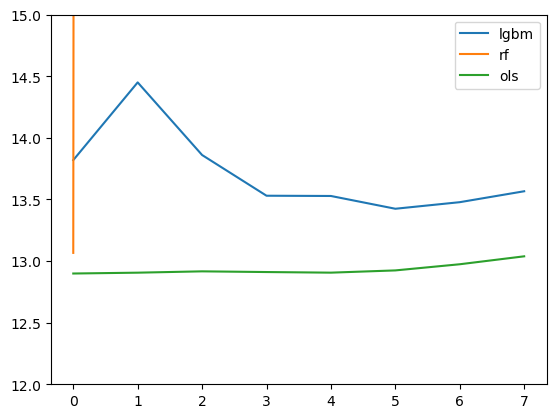

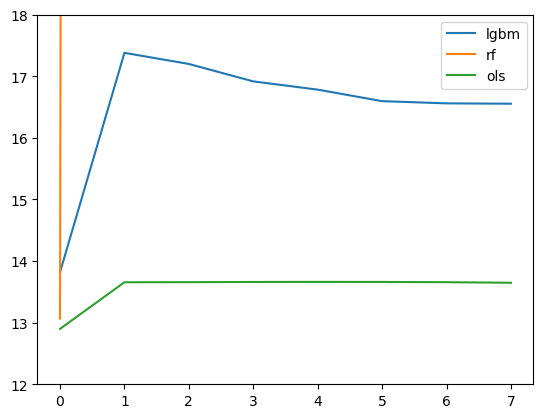

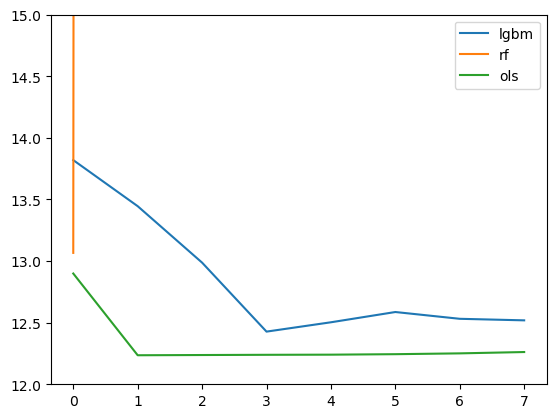

In [24]:
mse_hirid_df.plot(ylim=(12, 15))
mse_mimic_df.plot(ylim=(12, 18))
mse_miiv_df.plot(ylim=(12, 15))

### Anchor Regression + Residual RF  - location als anchor

In [138]:
gamma=2
# Centering
X_centered = X_train.drop(columns=['age', 'height', 'sex', 'weight']) - X_train.drop(columns=['age', 'height', 'sex', 'weight']).mean()
Y_centered = y_train - y_train.mean()

# Convert A to a NumPy array if it's a DataFrame for matrix operations
A_matrix = X_train[['age', 'sex', 'weight', 'height']].values   
# Fit a linear regression model for each independent variable in X_centered using A_matrix
residuals_X = []
fitted_values_X = []
residuals_y = []
fitted_values_y = []
for column in X_centered.columns:
    model = LR()
    model.fit(A_matrix, X_centered[column])
    residuals_X.append(X_centered[column] - model.predict(A_matrix))
    fitted_values_X.append(model.predict(A_matrix))

model = LR()
model.fit(A_matrix, Y_centered)
residuals_y.append(Y_centered - model.predict(A_matrix))
fitted_values_y.append(model.predict(A_matrix))

# Convert lists of residuals and fitted values to NumPy arrays
residuals_X_matrix = np.column_stack(residuals_X)
fitted_values_X_matrix = np.column_stack(fitted_values_X)
residuals_y = np.column_stack(residuals_y)
fitted_values_y = np.column_stack(fitted_values_y)

# Compute anchor_data by adding residuals to the scaled fitted values
anchor_data = residuals_X_matrix + np.sqrt(gamma) * fitted_values_X_matrix
anchor_data_target = residuals_y + np.sqrt(gamma) * fitted_values_y

anchor_reg = LR()
anchor_reg.fit(anchor_data, anchor_data_target)
pred_anchor = anchor_reg.predict(anchor_data)

res_anchor = anchor_data_target - pred_anchor
lgb_train = lgb.Dataset(data=X_centered, label=res_anchor,free_raw_data=False)
anchor_rf = lgb.train(params_rf,
                lgb_train,
                valid_sets=lgb_train,
                num_boost_round=10,
                )
pred_rf = anchor_rf.predict(X_centered).reshape(-1,1)
pred_anchor_rf = pred_anchor + pred_rf
print(mean_squared_error(Y_centered.values.reshape(-1, 1),pred_anchor_rf)**0.5)

12.109072462774071


/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/lightgbm/basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
